# Snowpark Container Services -- Scenario: "Jobs"

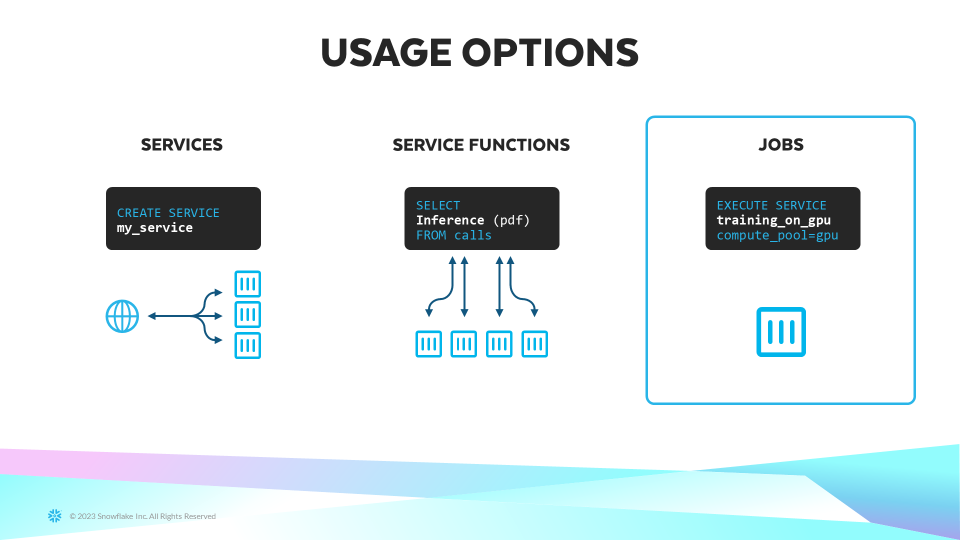

We are going to pretend we own a musical instrument store.

We want to be able to incorporate our natural language based customer reviews into the data science & decision making of our business.

In order to do so, we will need to turn our natural language data into embeddings.

In [1]:
import os 
import json

from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

from snowflake.snowpark import Session

import matplotlib.pyplot as plt
import seaborn as sns

## Connect to Snowflake / Snowpark Session

In [2]:
#Very easy to connect to your snowflake account

def get_token():
    with open('/snowflake/session/token', 'r') as f:
        return f.read()

connection_params = {
    'host': os.environ['SNOWFLAKE_HOST'],
    'port': os.environ['SNOWFLAKE_PORT'],
    'protocol': 'https',
    'account': os.environ['SNOWFLAKE_ACCOUNT'],
    'authenticator': 'oauth',
    'token': get_token(),
    'role': 'SERVICESNOW_USER_ROLE',
    'warehouse': 'MADKINS',
    'database': 'SPCS_DEMO',
    'schema': 'PROD'
}

session = Session.builder.configs(connection_params).create()
session.get_current_warehouse(), session.get_current_role(), session.get_current_database(), session.get_current_schema()

('"MADKINS"', '"SERVICESNOW_USER_ROLE"', '"SPCS_DEMO"', '"PROD"')

## Visualize our data

In [3]:
query = '''

    SELECT
        *
    FROM
        MUSIC_STORE_REVIEWS
    LIMIT 5
    
'''
df = session.sql(query).to_pandas()
df.head()

,DATE,PRODUCT,REVIEW,RATING
0,2023-06-15,Harmony G10 Electric Guitar,I am amazed by the sound quality of this guita...,5
1,2023-06-15,Melody M5000 Grand Piano,"The keys on this piano feel a bit stiff, but t...",3
2,2023-06-15,Rhythm R200 Drum Set,"I've been playing drums for years, and this dr...",5
3,2023-06-15,Serenade S700 Acoustic Guitar,I'm not impressed with this guitar. The tone i...,2
4,2023-06-15,Cadence C1500 Keyboard,This keyboard is great for beginners. It has a...,3


In [4]:
df['REVIEW'].values[0]

'I am amazed by the sound quality of this guitar! The pickups are incredible, and it plays like a dream. Definitely worth the price.'

## Load our NLP model

In [5]:
#Pre-run this guy
model = SentenceTransformer('all-mpnet-base-v2')

<Axes: >

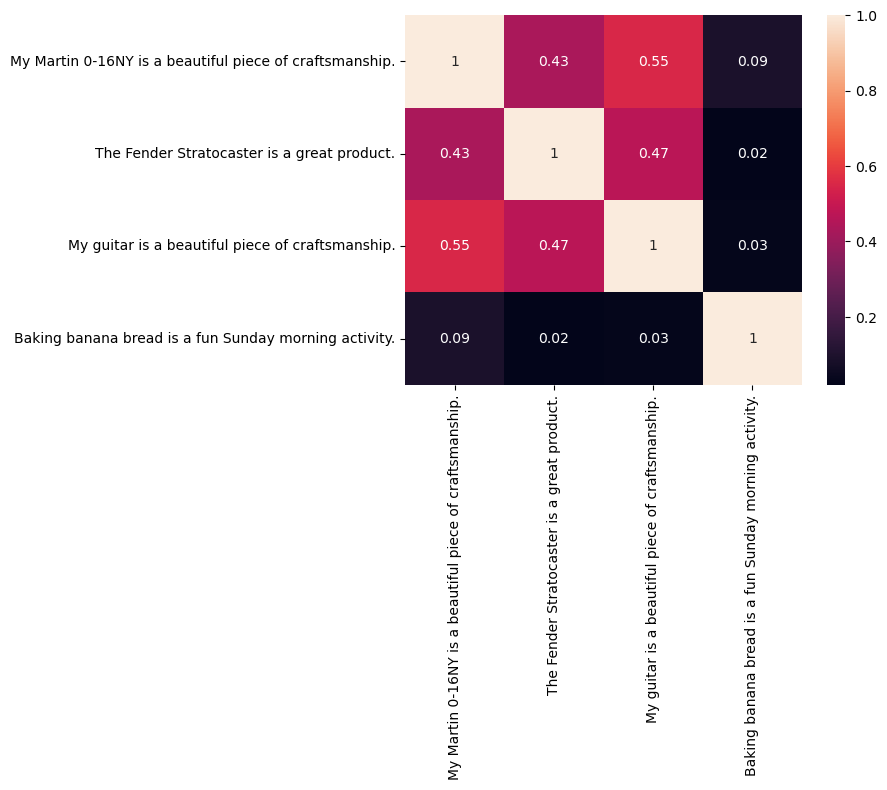

In [15]:
sentences = [
    "My Martin 0-16NY is a beautiful piece of craftsmanship.",
    "The Fender Stratocaster is a great product.",
    "My guitar is a beautiful piece of craftsmanship.",
    "Baking banana bread is a fun Sunday morning activity."
]

embeddings = model.encode(sentences)
similarities = cosine_similarity(embeddings).round(2)

similarities_df = pd.DataFrame(similarities)
similarities_df.columns = sentences
similarities_df.index = sentences

sns.heatmap(similarities_df, annot=True)

The embeddings from the baseline model suggest that these sentences are only somewhat similar, as the cosine similarity of just a bit over 0.5. In fact, we'd probably like for our model to think that all of the first three sentences are quite similar, as they all refer to guitars being of high quality. Fine-tuning on data relevant to our use case can help us improve the results.

Below, we fine-tune our model with a few examples to help it learn that a Martin-016NY is a type of guitar and that Fender is a guitar brand. We assign loose similarity scores as the `label` field to help teach the model which sentences are similar and which are dissimilar.

In [10]:
##Run Job

In [6]:
query = '''

    SHOW COMPUTE POOLS LIKE 'NVIDIA_A10Gx4';
    
'''

pd.DataFrame(session.sql(query).collect())

,name,state,min_nodes,max_nodes,instance_family,num_services,auto_suspend_secs,auto_resume,active_nodes,idle_nodes,created_on,resumed_on,updated_on,owner,comment
0,NVIDIA_A10GX4,ACTIVE,1,1,GPU_7,27,0,true,1,0,2023-06-07 17:47:16.740000-07:00,2023-06-21 16:11:26.152000-07:00,2023-06-23 09:20:03.068000-07:00,SERVICESNOW_USER_ROLE,None


In [9]:
query = '''

    EXECUTE SERVICE WITH
        COMPUTE_POOL = NVIDIA_A10Gx4
        SPEC = @snowpark_container_demo/job/job_manifest.yaml;

'''

session.sql(query).collect()

[Row(status='Execution submitted successfully as 01ad29c1-0001-a930-001f-9007005e1dd2.')]

In [8]:
query = '''

    CALL SYSTEM$GET_JOB_LOGS('01ad29c1-0001-a938-001f-9007005e2c32', 'nvidia-train',1000);

'''

print(session.sql(query).collect()[0].as_dict()['SYSTEM$GET_JOB_LOGS'])

/snowpark-container-demo/notebook
Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.42it/s]

Iteration: 100%|██████████| 1/1 [00:00<00:00, 14.28it/s]

Iteration: 100%|██████████| 1/1 [00:00<00:00, 14.28it/s]

Iteration: 100%|██████████| 1/1 [00:00<00:00, 14.57it/s]

Iteration: 100%|██████████| 1/1 [00:00<00:00, 14.47it/s]

Iteration: 100%|██████████| 1/1 [00:00<00:00, 14.51it/s]

Iteration: 100%|██████████| 1/1 [00:00<00:00, 14.47it/s]

Iteration: 100%|██████████| 1/1 [00:00<00:00, 14.35it/s]

Iteration: 100%|██████████| 1/1 [00:00<00:00, 14.50it/s]

Iteration: 100%|██████████| 1/1 [00:00<00:00, 14.59it/s]

Epoch:  21%|██        | 21/100 [00:01<00:05, 13.82it/s]



In [10]:
query = '''

    SHOW COMPUTE POOLS LIKE 'NVIDIA_A10Gx4';
    
'''

pd.DataFrame(session.sql(query).collect())

,name,state,min_nodes,max_nodes,instance_family,num_services,auto_suspend_secs,auto_resume,active_nodes,idle_nodes,created_on,resumed_on,updated_on,owner,comment
0,NVIDIA_A10GX4,ACTIVE,1,1,GPU_7,29,0,true,1,0,2023-06-07 17:47:16.740000-07:00,2023-06-21 16:11:26.152000-07:00,2023-06-23 09:33:46.893000-07:00,SERVICESNOW_USER_ROLE,None


In [11]:
query = '''

    ALTER COMPUTE POOL NVIDIA_A10Gx4 SUSPEND;

'''
session.sql(query).collect()

[Row(status='Statement executed successfully.')]

In [12]:
query = '''

    SHOW COMPUTE POOLS LIKE 'NVIDIA_A10Gx4';
    
'''

pd.DataFrame(session.sql(query).collect())

,name,state,min_nodes,max_nodes,instance_family,num_services,auto_suspend_secs,auto_resume,active_nodes,idle_nodes,created_on,resumed_on,updated_on,owner,comment
0,NVIDIA_A10GX4,STOPPING,1,1,GPU_7,29,0,true,1,0,2023-06-07 17:47:16.740000-07:00,2023-06-21 16:11:26.152000-07:00,2023-06-23 09:35:15.598000-07:00,SERVICESNOW_USER_ROLE,None


<Axes: title={'center': 'Similarity Scores from the Fine-Tuned Model'}>

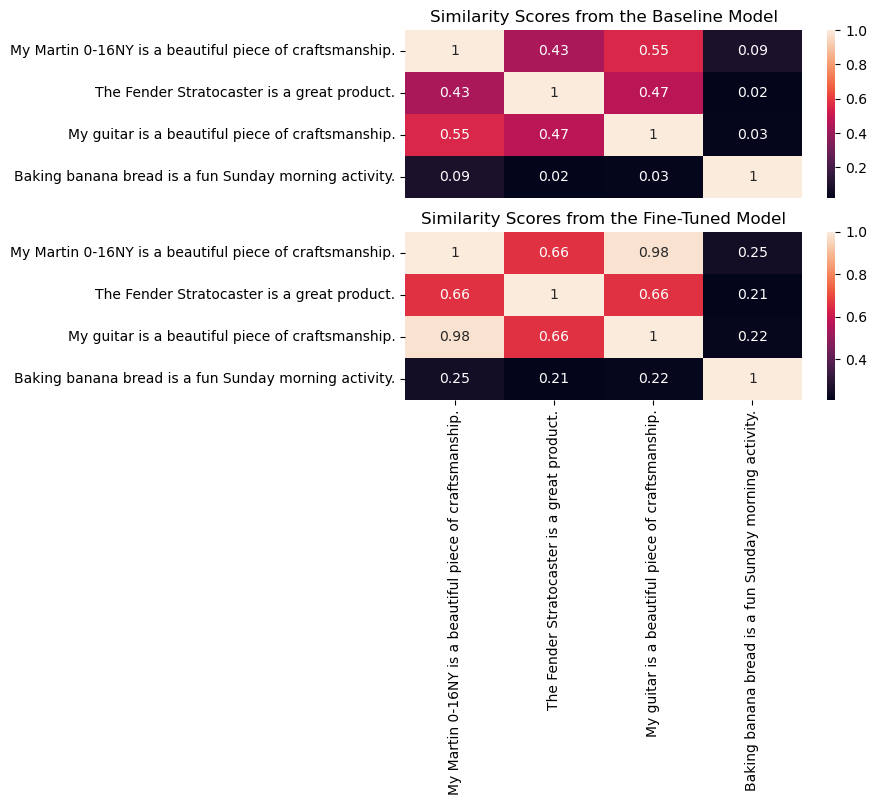

In [16]:
fine_tuned = SentenceTransformer('/rapids/notebooks/snowpark-container-demo/notebook/fine-tuned-model')

sentences = [
    "My Martin 0-16NY is a beautiful piece of craftsmanship.",
    "The Fender Stratocaster is a great product.",
    "My guitar is a beautiful piece of craftsmanship.",
    "Baking banana bread is a fun Sunday morning activity."
]

new_embeddings = fine_tuned.encode(sentences)
new_similarities = cosine_similarity(new_embeddings).round(2)

new_similarities_df = pd.DataFrame(new_similarities)
new_similarities_df.columns = sentences
new_similarities_df.index = sentences

fig, axes = plt.subplots(2, 1)

axes[0].set_title("Similarity Scores from the Baseline Model")
axes[1].set_title("Similarity Scores from the Fine-Tuned Model")
sns.heatmap(similarities_df, annot=True, ax=axes[0], xticklabels="")
sns.heatmap(new_similarities_df, annot=True, ax=axes[1])